In [1]:
import pandas as pd
import numpy as np
from csv_cleaner import clean_df

# Chargement des données
df = pd.read_csv('../res/train.csv')

# Nettoyage des données
df = clean_df(df)
df.head()

,Brand,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,New_Price,Price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,37.24,998.0,58.16,0,1.75
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,0,12.50
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,1,4.50
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,0,6.00
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,0,17.74


In [2]:
# Séparation des données en apprentissage et test
from sklearn.model_selection import train_test_split

X = df.drop(columns= ['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor as GBR
from pipeline_GBR import pipeline_create


# Mettre à jour la grille de paramètres pour cibler directement GradientBoostingRegressor au sein du pipeline
param_grid = {
    'gradientboostingregressor__n_estimators': [100, 200, 300],
    'gradientboostingregressor__max_depth': [5, 7],
    'gradientboostingregressor__min_samples_split': [2, 4],
    'gradientboostingregressor__min_samples_leaf': [1, 3],
    'gradientboostingregressor__max_features': ['sqrt'],
    'gradientboostingregressor__subsample': [1.0]
}

# Construire le pipeline avec GradientBoostingRegressor comme 'regressor'
pipeline = pipeline_create(X_train, GBR(random_state=0))

# Appliquer GridSearchCV sur le pipeline au lieu de juste le modèle
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Year',
                                                                          'Kilometers_Driven',
                                                                          'Mileage',
                                                                          'Engine',
                                                                          'Power',
                                                                          'New_Price']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotE...
                                        GradientBoostingRegressor(random_state=0))]),
             param_grid={'gradientboostingregressor__max_depth': [5, 7],
                         'gradientboostingregressor__max_features': ['sqrt'],
                         'gradientboostingregressor__min_samples_leaf': [1, 3],
                         'gradientboostingregressor__min_samples_split': [2, 4],
                         'gradientboostingregressor__n_estimators': [100, 200,
                                                                     300],
                         'gradientboostingregressor__subsample': [1.0]},
             scoring='neg_mean_squared_error')

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

# Configuration de KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Initialiser des listes pour enregistrer les scores pour chaque pli
mse_scores = []
rmse_scores = []
r2_scores = []
train_sizes = []

# Boucler sur chaque pli défini par KFold
for train_index, test_index in kf.split(X):

    # On redéfini les données d'apprentissage et de test pour chaque pli
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Calculer la taille du jeu d'entraînement pour ce pli
    train_size = len(train_index)
    train_sizes.append(train_size)

    # Prediction du modèle
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    # Calcul du MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    # Calcul du RMSE
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    
    # Calcul du R2
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

print(f"MSE : {mse_scores}")
print(f"RMSE : {rmse_scores}")
print(f"R² : {r2_scores}")

print("Mean MSE:", np.mean(mse_scores))
print("Mean RMSE:", np.mean(rmse_scores))
print("Mean R²:", np.mean(r2_scores))

MSE : [4.009802900637965, 3.441686610333497, 4.4842560070077555, 4.011666549952676, 4.778713348505594]
RMSE : [2.0024492254831245, 1.8551783230550902, 2.117606197338815, 2.0029145138903646, 2.1860268407559853]
R² : [0.9343072495632867, 0.9461279525028822, 0.9253492488694726, 0.934222871378822, 0.9232386446381942]
Mean MSE: 4.145225083287498
Mean RMSE: 2.032835020104676
Mean R²: 0.9326491933905317


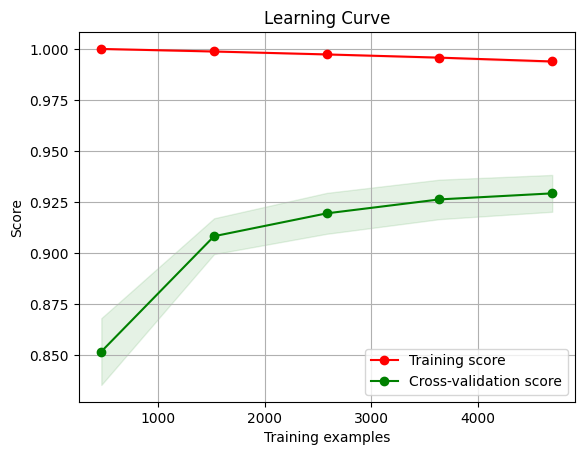

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(grid_search.best_estimator_, "Learning Curve", X, y)
plt.show()

In [10]:
# Enregistrement du modèle

import pickle

#Chemin où vous souhaitez enregistrer le modèle
chemin_fichier = 'GBR.pkl'

with open(chemin_fichier, 'wb') as fichier:
    pickle.dump(pipeline, fichier)

print(f"Modèle enregistré avec succès dans {chemin_fichier}")


Modèle enregistré avec succès dans GBR.pkl


In [ ]:
#Utilsation du modèle

# import pickle

# with open('GBR.pkl', 'rb') as fichier:
#     GBR = pickle.load(fichier)

# donnees_de_test = pd.read_csv('../res/clean_train.csv')
# predictions = GBR.predict(donnees_de_test)

# print(predictions)
# print(len(predictions))